# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.83KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

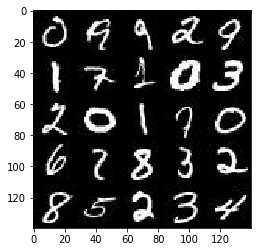

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

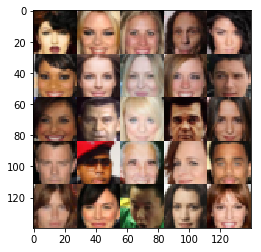

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,[None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32,[None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [97]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator",reuse=reuse):
        # 28*28*3
        cov1 = tf.layers.conv2d(images,64,3,strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        # leak relu
        relu1 = tf.maximum(alpha * cov1, cov1)
        # 14*14*64
        
        cov2 = tf.layers.conv2d(relu1,128,3,strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(cov2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7*7*128
        
        cov3 = tf.layers.conv2d(relu2,256,3,strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(cov3,training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4*4*256
        
        flat = tf.reshape(relu3, (-1,np.prod(relu3.get_shape().as_list()[1:])))
        print("shape:"+str(np.prod(relu3.get_shape().as_list()[1:])))
        #flat = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

shape:4096
shape:4096
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [98]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training,
    用来给batch_normal来标记的，它内部表示用的normal的均值是batch的还是global的
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("generator",reuse=not is_train):
        input1 = tf.layers.dense(z,4*4*512)
        input1 = tf.reshape(input1,(-1, 4, 4, 512))
        input1 = tf.layers.batch_normalization(input1, training=is_train)
        input1 = tf.maximum(alpha * input1, input1)
        # 4*4*512
        
        input2 = tf.layers.conv2d_transpose(input1,256, 4, strides=1, padding='valid',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        input2 = tf.layers.batch_normalization(input2, training=is_train)
        input2 = tf.maximum(alpha * input2, input2)
        # 7*7*256
        
        input3 = tf.layers.conv2d_transpose(input2,128, 3, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        input3 = tf.layers.batch_normalization(input3, training=is_train)
        input3 = tf.maximum(alpha * input3, input3)
        # 14*14*256
        
        input2 = tf.layers.conv2d_transpose(input3,out_channel_dim, 3, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        
        # 注意：这边输出的是-1--1
        out = tf.tanh(input2)
    
        print(out.get_shape().as_list())
        # 28*28*3
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

[None, 28, 28, 5]
[None, 28, 28, 5]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [99]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # 注意这里要求输入-0.5--0.5
    g_out= generator(input_z, out_channel_dim, is_train=True)*0.5
    
    # gan_mnist那一课的办法
    smooth=0
    d_out_real,d_logits_real =discriminator(input_real, reuse=False)
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_out_real) * (1 - smooth)))
    
    
    d_out_fake,d_logits_fake =discriminator(g_out, reuse=True)
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_out_fake)))
    
    d_loss=d_loss_real+d_loss_fake
    
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_out_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

[None, 28, 28, 4]
shape:4096
shape:4096
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [100]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    var_g=[var for var in tf.trainable_variables() if var.name.startswith("generator")]
    var_d=[var for var in tf.trainable_variables() if var.name.startswith("discriminator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt=tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=var_d)
        g_opt=tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=var_g)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [101]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [102]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width=data_shape[1]
    image_height=data_shape[2]
    image_channels=data_shape[-1]
    input_real, input_z, input_learning_rate =model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt=model_opt(d_loss, g_loss, input_learning_rate, beta1)
    batch_index =0
    losses=[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_index+=1
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                # TODO: Train Model
                _ = sess.run(d_opt,feed_dict={input_real: batch_images, input_z: batch_z,input_learning_rate:learning_rate})
                
                _ = sess.run(g_opt,feed_dict={input_z: batch_z,input_learning_rate:learning_rate,input_real: batch_images})
                ## 
                if(batch_index%20==0):
                    train_loss_d=d_loss.eval({input_real: batch_images, input_z: batch_z,input_learning_rate:learning_rate})
                    train_loss_g=g_loss.eval({input_z: batch_z,input_learning_rate:learning_rate})
                    # Save losses to view after training 
                    losses.append((train_loss_d, train_loss_g))
                    print("Epoch {}/{}, Batch:{}...".format(epoch_i+1, epoch_count,batch_index),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if(batch_index%100==0):
#                     train_loss_d=d_loss.eval({input_real: batch_images, input_z: batch_z,input_learning_rate:learning_rate})
#                     train_loss_g=g_loss.eval({input_z: batch_z,input_learning_rate:learning_rate})
                    
#                     print("Epoch {}/{}, Batch:{}...".format(epoch_i+1, epoch_count,batch_index),
#                           "Discriminator Loss: {:.4f}...".format(train_loss_d),
#                           "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # see picture
                    show_generator_output(sess,25,input_z,image_channels,data_image_mode) 
                
    return losses


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

[None, 28, 28, 1]
shape:4096
shape:4096
Epoch 1/2, Batch:20... Discriminator Loss: 0.2402... Generator Loss: 2.1136
Epoch 1/2, Batch:40... Discriminator Loss: 0.1208... Generator Loss: 3.1756
Epoch 1/2, Batch:60... Discriminator Loss: 0.1068... Generator Loss: 3.4204
Epoch 1/2, Batch:80... Discriminator Loss: 0.3334... Generator Loss: 1.7504
Epoch 1/2, Batch:100... Discriminator Loss: 0.2931... Generator Loss: 2.9724
[None, 28, 28, 1]


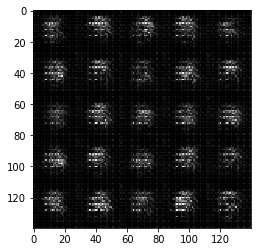

Epoch 1/2, Batch:120... Discriminator Loss: 0.1936... Generator Loss: 2.5769
Epoch 1/2, Batch:140... Discriminator Loss: 0.4431... Generator Loss: 2.6406
Epoch 1/2, Batch:160... Discriminator Loss: 1.5577... Generator Loss: 0.5632
Epoch 1/2, Batch:180... Discriminator Loss: 0.6946... Generator Loss: 2.0085
Epoch 1/2, Batch:200... Discriminator Loss: 0.4760... Generator Loss: 1.7371
[None, 28, 28, 1]


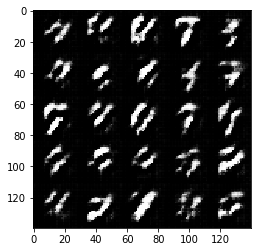

Epoch 1/2, Batch:220... Discriminator Loss: 0.6811... Generator Loss: 1.2015
Epoch 1/2, Batch:240... Discriminator Loss: 0.7661... Generator Loss: 1.8888
Epoch 1/2, Batch:260... Discriminator Loss: 0.3928... Generator Loss: 2.4306
Epoch 1/2, Batch:280... Discriminator Loss: 0.8631... Generator Loss: 0.9150
Epoch 1/2, Batch:300... Discriminator Loss: 1.0006... Generator Loss: 0.7594
[None, 28, 28, 1]


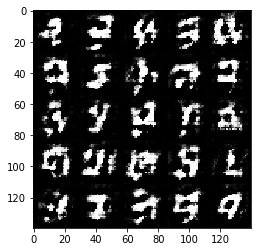

Epoch 1/2, Batch:320... Discriminator Loss: 0.8243... Generator Loss: 1.8627
Epoch 1/2, Batch:340... Discriminator Loss: 0.7654... Generator Loss: 1.0875
Epoch 1/2, Batch:360... Discriminator Loss: 0.5282... Generator Loss: 1.6565
Epoch 1/2, Batch:380... Discriminator Loss: 0.8193... Generator Loss: 0.9114
Epoch 1/2, Batch:400... Discriminator Loss: 1.4394... Generator Loss: 0.3920
[None, 28, 28, 1]


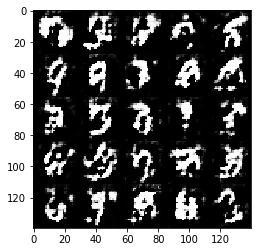

Epoch 1/2, Batch:420... Discriminator Loss: 0.5810... Generator Loss: 1.5459
Epoch 1/2, Batch:440... Discriminator Loss: 0.8597... Generator Loss: 1.4960
Epoch 1/2, Batch:460... Discriminator Loss: 0.7134... Generator Loss: 1.3393
Epoch 1/2, Batch:480... Discriminator Loss: 0.6552... Generator Loss: 1.5500
Epoch 1/2, Batch:500... Discriminator Loss: 0.6421... Generator Loss: 1.9715
[None, 28, 28, 1]


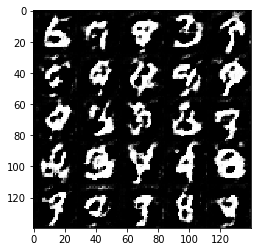

Epoch 1/2, Batch:520... Discriminator Loss: 0.6308... Generator Loss: 1.6488
Epoch 1/2, Batch:540... Discriminator Loss: 0.5708... Generator Loss: 1.9140
Epoch 1/2, Batch:560... Discriminator Loss: 1.4969... Generator Loss: 3.2768
Epoch 1/2, Batch:580... Discriminator Loss: 0.8498... Generator Loss: 0.9429
Epoch 1/2, Batch:600... Discriminator Loss: 0.7051... Generator Loss: 1.3010
[None, 28, 28, 1]


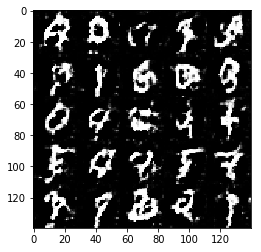

Epoch 1/2, Batch:620... Discriminator Loss: 0.8137... Generator Loss: 0.8805
Epoch 1/2, Batch:640... Discriminator Loss: 0.7671... Generator Loss: 1.8037
Epoch 1/2, Batch:660... Discriminator Loss: 0.6466... Generator Loss: 1.5597
Epoch 1/2, Batch:680... Discriminator Loss: 1.1264... Generator Loss: 0.5562
Epoch 1/2, Batch:700... Discriminator Loss: 0.8393... Generator Loss: 1.1912
[None, 28, 28, 1]


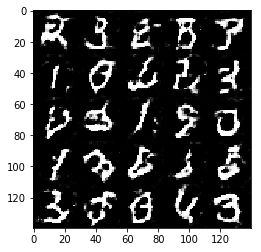

Epoch 1/2, Batch:720... Discriminator Loss: 0.9113... Generator Loss: 1.5180
Epoch 1/2, Batch:740... Discriminator Loss: 1.0160... Generator Loss: 0.6178
Epoch 1/2, Batch:760... Discriminator Loss: 0.9751... Generator Loss: 0.7595
Epoch 1/2, Batch:780... Discriminator Loss: 0.7630... Generator Loss: 1.1582
Epoch 1/2, Batch:800... Discriminator Loss: 0.7210... Generator Loss: 1.0771
[None, 28, 28, 1]


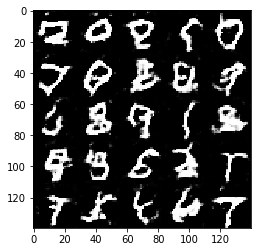

Epoch 1/2, Batch:820... Discriminator Loss: 0.6809... Generator Loss: 1.7486
Epoch 1/2, Batch:840... Discriminator Loss: 1.4952... Generator Loss: 0.3369
Epoch 1/2, Batch:860... Discriminator Loss: 1.0050... Generator Loss: 0.6193
Epoch 1/2, Batch:880... Discriminator Loss: 0.8047... Generator Loss: 0.8142
Epoch 1/2, Batch:900... Discriminator Loss: 0.8585... Generator Loss: 0.7589
[None, 28, 28, 1]


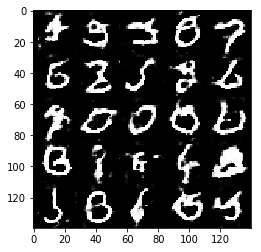

Epoch 1/2, Batch:920... Discriminator Loss: 0.9307... Generator Loss: 1.6213
Epoch 2/2, Batch:940... Discriminator Loss: 0.5455... Generator Loss: 2.0092
Epoch 2/2, Batch:960... Discriminator Loss: 0.7817... Generator Loss: 0.9061
Epoch 2/2, Batch:980... Discriminator Loss: 0.8407... Generator Loss: 0.7734
Epoch 2/2, Batch:1000... Discriminator Loss: 0.7507... Generator Loss: 0.8783
[None, 28, 28, 1]


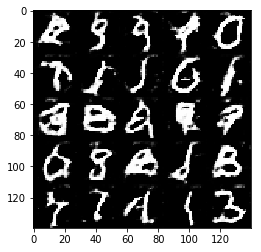

Epoch 2/2, Batch:1020... Discriminator Loss: 1.5437... Generator Loss: 2.5315
Epoch 2/2, Batch:1040... Discriminator Loss: 0.6253... Generator Loss: 1.0925
Epoch 2/2, Batch:1060... Discriminator Loss: 0.9300... Generator Loss: 0.6605
Epoch 2/2, Batch:1080... Discriminator Loss: 0.6227... Generator Loss: 1.0361
Epoch 2/2, Batch:1100... Discriminator Loss: 0.9894... Generator Loss: 0.5803
[None, 28, 28, 1]


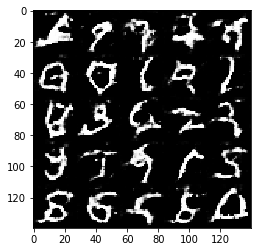

Epoch 2/2, Batch:1120... Discriminator Loss: 0.7345... Generator Loss: 1.0256
Epoch 2/2, Batch:1140... Discriminator Loss: 0.7560... Generator Loss: 0.8856
Epoch 2/2, Batch:1160... Discriminator Loss: 0.7208... Generator Loss: 0.9127
Epoch 2/2, Batch:1180... Discriminator Loss: 1.2452... Generator Loss: 1.5082
Epoch 2/2, Batch:1200... Discriminator Loss: 0.6319... Generator Loss: 1.6384
[None, 28, 28, 1]


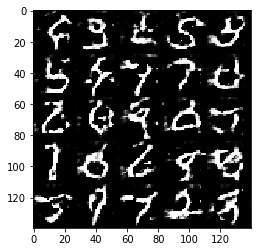

Epoch 2/2, Batch:1220... Discriminator Loss: 0.6787... Generator Loss: 1.5723
Epoch 2/2, Batch:1240... Discriminator Loss: 0.6099... Generator Loss: 1.5745
Epoch 2/2, Batch:1260... Discriminator Loss: 0.9169... Generator Loss: 0.6614
Epoch 2/2, Batch:1280... Discriminator Loss: 0.4888... Generator Loss: 1.5689
Epoch 2/2, Batch:1300... Discriminator Loss: 0.3503... Generator Loss: 1.8623
[None, 28, 28, 1]


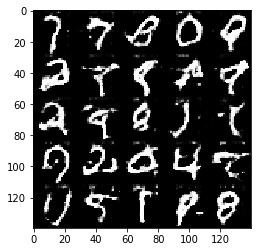

Epoch 2/2, Batch:1320... Discriminator Loss: 0.4920... Generator Loss: 1.3288
Epoch 2/2, Batch:1340... Discriminator Loss: 0.7797... Generator Loss: 1.2345
Epoch 2/2, Batch:1360... Discriminator Loss: 0.7593... Generator Loss: 1.4692
Epoch 2/2, Batch:1380... Discriminator Loss: 0.6522... Generator Loss: 1.2905
Epoch 2/2, Batch:1400... Discriminator Loss: 0.5860... Generator Loss: 1.2233
[None, 28, 28, 1]


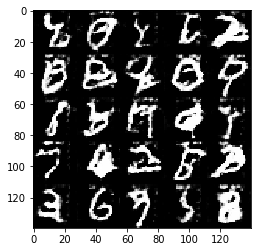

Epoch 2/2, Batch:1420... Discriminator Loss: 0.8761... Generator Loss: 0.7373
Epoch 2/2, Batch:1440... Discriminator Loss: 0.6994... Generator Loss: 1.0173
Epoch 2/2, Batch:1460... Discriminator Loss: 0.5925... Generator Loss: 2.6999
Epoch 2/2, Batch:1480... Discriminator Loss: 0.6612... Generator Loss: 1.1962
Epoch 2/2, Batch:1500... Discriminator Loss: 0.8266... Generator Loss: 1.7575
[None, 28, 28, 1]


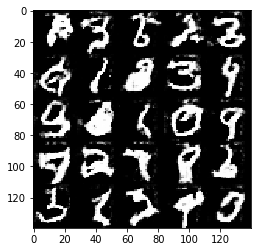

Epoch 2/2, Batch:1520... Discriminator Loss: 0.6894... Generator Loss: 1.9564
Epoch 2/2, Batch:1540... Discriminator Loss: 0.6052... Generator Loss: 1.3258
Epoch 2/2, Batch:1560... Discriminator Loss: 1.1647... Generator Loss: 0.4869
Epoch 2/2, Batch:1580... Discriminator Loss: 0.6585... Generator Loss: 1.2773
Epoch 2/2, Batch:1600... Discriminator Loss: 0.6406... Generator Loss: 1.0776
[None, 28, 28, 1]


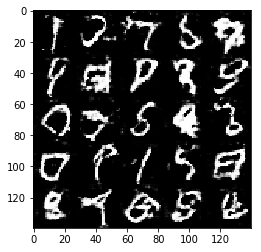

Epoch 2/2, Batch:1620... Discriminator Loss: 0.5152... Generator Loss: 1.3622
Epoch 2/2, Batch:1640... Discriminator Loss: 0.7630... Generator Loss: 0.8598
Epoch 2/2, Batch:1660... Discriminator Loss: 0.5011... Generator Loss: 1.7258
Epoch 2/2, Batch:1680... Discriminator Loss: 0.4220... Generator Loss: 1.6661
Epoch 2/2, Batch:1700... Discriminator Loss: 0.7046... Generator Loss: 1.1334
[None, 28, 28, 1]


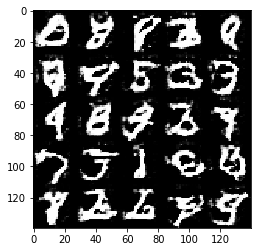

Epoch 2/2, Batch:1720... Discriminator Loss: 0.3997... Generator Loss: 1.9555
Epoch 2/2, Batch:1740... Discriminator Loss: 0.8455... Generator Loss: 0.9026
Epoch 2/2, Batch:1760... Discriminator Loss: 0.7341... Generator Loss: 2.3704
Epoch 2/2, Batch:1780... Discriminator Loss: 1.4086... Generator Loss: 0.3979
Epoch 2/2, Batch:1800... Discriminator Loss: 0.6193... Generator Loss: 1.1057
[None, 28, 28, 1]


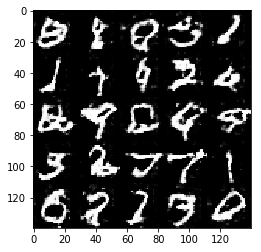

Epoch 2/2, Batch:1820... Discriminator Loss: 0.5656... Generator Loss: 1.4646
Epoch 2/2, Batch:1840... Discriminator Loss: 0.6733... Generator Loss: 1.0274
Epoch 2/2, Batch:1860... Discriminator Loss: 0.5213... Generator Loss: 1.2833


In [103]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

[None, 28, 28, 3]
shape:4096
shape:4096
Epoch 1/1, Batch:20... Discriminator Loss: 0.5803... Generator Loss: 1.1561
Epoch 1/1, Batch:40... Discriminator Loss: 0.1788... Generator Loss: 2.2382
Epoch 1/1, Batch:60... Discriminator Loss: 0.2416... Generator Loss: 2.4048
Epoch 1/1, Batch:80... Discriminator Loss: 0.1453... Generator Loss: 2.3527
Epoch 1/1, Batch:100... Discriminator Loss: 0.1279... Generator Loss: 2.5893
[None, 28, 28, 3]


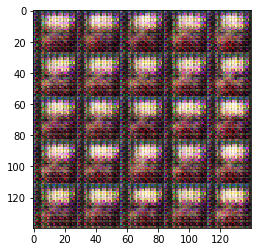

Epoch 1/1, Batch:120... Discriminator Loss: 0.1258... Generator Loss: 2.6365
Epoch 1/1, Batch:140... Discriminator Loss: 0.0969... Generator Loss: 3.2646
Epoch 1/1, Batch:160... Discriminator Loss: 0.1367... Generator Loss: 2.2998
Epoch 1/1, Batch:180... Discriminator Loss: 0.6257... Generator Loss: 14.5495
Epoch 1/1, Batch:200... Discriminator Loss: 0.0416... Generator Loss: 3.9415
[None, 28, 28, 3]


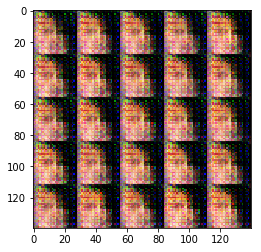

Epoch 1/1, Batch:220... Discriminator Loss: 0.0621... Generator Loss: 4.4016
Epoch 1/1, Batch:240... Discriminator Loss: 0.0680... Generator Loss: 2.8927
Epoch 1/1, Batch:260... Discriminator Loss: 0.0580... Generator Loss: 3.3425
Epoch 1/1, Batch:280... Discriminator Loss: 0.0369... Generator Loss: 3.9051
Epoch 1/1, Batch:300... Discriminator Loss: 0.0266... Generator Loss: 4.2446
[None, 28, 28, 3]


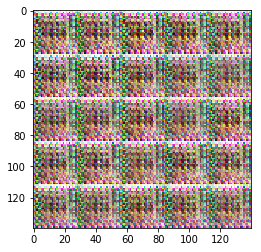

Epoch 1/1, Batch:320... Discriminator Loss: 0.0130... Generator Loss: 10.9943
Epoch 1/1, Batch:340... Discriminator Loss: 0.1237... Generator Loss: 7.8561
Epoch 1/1, Batch:360... Discriminator Loss: 0.1560... Generator Loss: 6.9945
Epoch 1/1, Batch:380... Discriminator Loss: 0.3108... Generator Loss: 2.8506
Epoch 1/1, Batch:400... Discriminator Loss: 0.5904... Generator Loss: 0.9890
[None, 28, 28, 3]


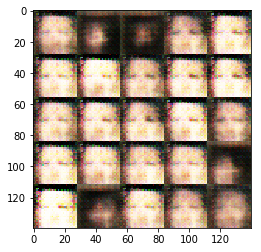

Epoch 1/1, Batch:420... Discriminator Loss: 1.8384... Generator Loss: 7.1040
Epoch 1/1, Batch:440... Discriminator Loss: 0.5036... Generator Loss: 2.7391
Epoch 1/1, Batch:460... Discriminator Loss: 0.4822... Generator Loss: 3.9129
Epoch 1/1, Batch:480... Discriminator Loss: 0.3480... Generator Loss: 1.8679
Epoch 1/1, Batch:500... Discriminator Loss: 1.3067... Generator Loss: 7.1284
[None, 28, 28, 3]


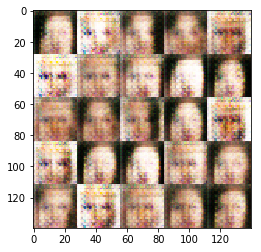

Epoch 1/1, Batch:520... Discriminator Loss: 1.0196... Generator Loss: 0.6208
Epoch 1/1, Batch:540... Discriminator Loss: 0.5231... Generator Loss: 1.9686
Epoch 1/1, Batch:560... Discriminator Loss: 0.6933... Generator Loss: 1.1199
Epoch 1/1, Batch:580... Discriminator Loss: 0.5587... Generator Loss: 1.3999
Epoch 1/1, Batch:600... Discriminator Loss: 0.6075... Generator Loss: 2.3558
[None, 28, 28, 3]


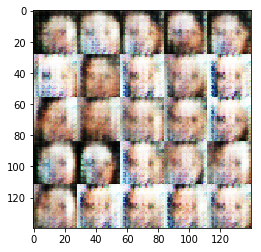

Epoch 1/1, Batch:620... Discriminator Loss: 1.0356... Generator Loss: 0.8017
Epoch 1/1, Batch:640... Discriminator Loss: 0.8817... Generator Loss: 1.2620
Epoch 1/1, Batch:660... Discriminator Loss: 0.6329... Generator Loss: 1.8621
Epoch 1/1, Batch:680... Discriminator Loss: 0.7386... Generator Loss: 1.1347
Epoch 1/1, Batch:700... Discriminator Loss: 0.5237... Generator Loss: 2.2375
[None, 28, 28, 3]


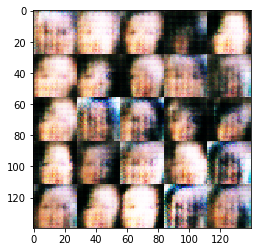

Epoch 1/1, Batch:720... Discriminator Loss: 0.4382... Generator Loss: 2.3356
Epoch 1/1, Batch:740... Discriminator Loss: 0.6255... Generator Loss: 2.4264
Epoch 1/1, Batch:760... Discriminator Loss: 0.5751... Generator Loss: 1.8398
Epoch 1/1, Batch:780... Discriminator Loss: 0.9673... Generator Loss: 0.8132
Epoch 1/1, Batch:800... Discriminator Loss: 0.7332... Generator Loss: 1.8667
[None, 28, 28, 3]


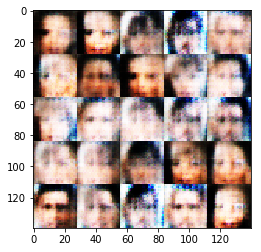

Epoch 1/1, Batch:820... Discriminator Loss: 0.5648... Generator Loss: 1.6629
Epoch 1/1, Batch:840... Discriminator Loss: 0.5965... Generator Loss: 1.5202
Epoch 1/1, Batch:860... Discriminator Loss: 0.7513... Generator Loss: 2.6697
Epoch 1/1, Batch:880... Discriminator Loss: 1.5666... Generator Loss: 0.5056
Epoch 1/1, Batch:900... Discriminator Loss: 0.6497... Generator Loss: 1.3450
[None, 28, 28, 3]


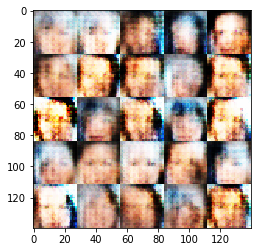

Epoch 1/1, Batch:920... Discriminator Loss: 0.8808... Generator Loss: 1.6017
Epoch 1/1, Batch:940... Discriminator Loss: 0.5076... Generator Loss: 2.6644
Epoch 1/1, Batch:960... Discriminator Loss: 1.0289... Generator Loss: 1.3581
Epoch 1/1, Batch:980... Discriminator Loss: 0.8908... Generator Loss: 1.5744
Epoch 1/1, Batch:1000... Discriminator Loss: 0.6289... Generator Loss: 1.7967
[None, 28, 28, 3]


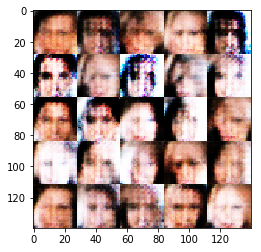

Epoch 1/1, Batch:1020... Discriminator Loss: 0.8002... Generator Loss: 1.1877
Epoch 1/1, Batch:1040... Discriminator Loss: 0.7164... Generator Loss: 1.2262
Epoch 1/1, Batch:1060... Discriminator Loss: 0.7257... Generator Loss: 3.1536
Epoch 1/1, Batch:1080... Discriminator Loss: 0.9622... Generator Loss: 1.1630
Epoch 1/1, Batch:1100... Discriminator Loss: 1.0185... Generator Loss: 2.4871
[None, 28, 28, 3]


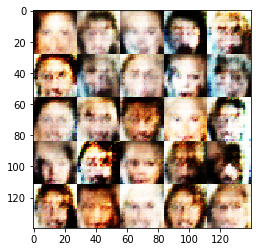

Epoch 1/1, Batch:1120... Discriminator Loss: 0.9757... Generator Loss: 0.7247
Epoch 1/1, Batch:1140... Discriminator Loss: 0.7435... Generator Loss: 1.7122
Epoch 1/1, Batch:1160... Discriminator Loss: 0.9268... Generator Loss: 1.6015
Epoch 1/1, Batch:1180... Discriminator Loss: 1.0611... Generator Loss: 0.9038
Epoch 1/1, Batch:1200... Discriminator Loss: 0.7090... Generator Loss: 1.4072
[None, 28, 28, 3]


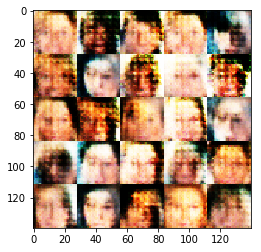

Epoch 1/1, Batch:1220... Discriminator Loss: 1.2030... Generator Loss: 0.6420
Epoch 1/1, Batch:1240... Discriminator Loss: 1.0389... Generator Loss: 1.9905
Epoch 1/1, Batch:1260... Discriminator Loss: 1.0397... Generator Loss: 1.1416
Epoch 1/1, Batch:1280... Discriminator Loss: 0.9779... Generator Loss: 1.4718
Epoch 1/1, Batch:1300... Discriminator Loss: 1.0608... Generator Loss: 0.7742
[None, 28, 28, 3]


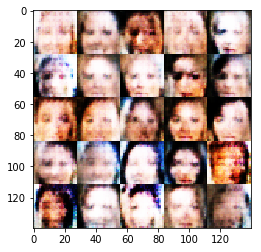

Epoch 1/1, Batch:1320... Discriminator Loss: 0.9276... Generator Loss: 1.5218
Epoch 1/1, Batch:1340... Discriminator Loss: 1.0580... Generator Loss: 1.1862
Epoch 1/1, Batch:1360... Discriminator Loss: 1.1137... Generator Loss: 0.8453
Epoch 1/1, Batch:1380... Discriminator Loss: 0.9550... Generator Loss: 1.0568
Epoch 1/1, Batch:1400... Discriminator Loss: 0.8059... Generator Loss: 1.6586
[None, 28, 28, 3]


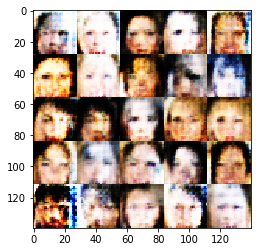

Epoch 1/1, Batch:1420... Discriminator Loss: 0.8941... Generator Loss: 1.5412
Epoch 1/1, Batch:1440... Discriminator Loss: 1.0019... Generator Loss: 2.2580
Epoch 1/1, Batch:1460... Discriminator Loss: 0.9922... Generator Loss: 1.4952
Epoch 1/1, Batch:1480... Discriminator Loss: 1.0531... Generator Loss: 1.0427
Epoch 1/1, Batch:1500... Discriminator Loss: 1.0117... Generator Loss: 1.7127
[None, 28, 28, 3]


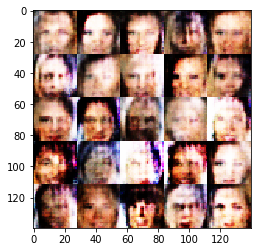

Epoch 1/1, Batch:1520... Discriminator Loss: 0.8651... Generator Loss: 1.4086
Epoch 1/1, Batch:1540... Discriminator Loss: 0.9838... Generator Loss: 0.8159
Epoch 1/1, Batch:1560... Discriminator Loss: 0.8298... Generator Loss: 1.5039
Epoch 1/1, Batch:1580... Discriminator Loss: 1.2613... Generator Loss: 0.7689
Epoch 1/1, Batch:1600... Discriminator Loss: 1.4055... Generator Loss: 0.7269
[None, 28, 28, 3]


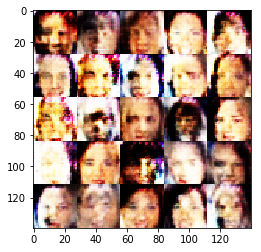

Epoch 1/1, Batch:1620... Discriminator Loss: 0.8956... Generator Loss: 1.0917
Epoch 1/1, Batch:1640... Discriminator Loss: 1.1975... Generator Loss: 1.4108
Epoch 1/1, Batch:1660... Discriminator Loss: 0.9499... Generator Loss: 1.1618
Epoch 1/1, Batch:1680... Discriminator Loss: 0.8564... Generator Loss: 1.2178
Epoch 1/1, Batch:1700... Discriminator Loss: 0.8733... Generator Loss: 1.5734
[None, 28, 28, 3]


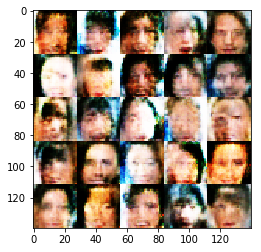

Epoch 1/1, Batch:1720... Discriminator Loss: 1.0676... Generator Loss: 1.2526
Epoch 1/1, Batch:1740... Discriminator Loss: 0.9456... Generator Loss: 1.5400
Epoch 1/1, Batch:1760... Discriminator Loss: 0.8797... Generator Loss: 1.1491
Epoch 1/1, Batch:1780... Discriminator Loss: 1.2794... Generator Loss: 1.2612
Epoch 1/1, Batch:1800... Discriminator Loss: 1.0629... Generator Loss: 0.8251
[None, 28, 28, 3]


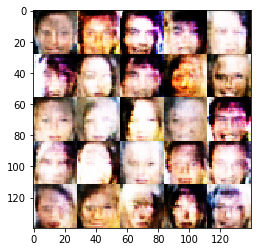

Epoch 1/1, Batch:1820... Discriminator Loss: 0.8334... Generator Loss: 1.7979
Epoch 1/1, Batch:1840... Discriminator Loss: 1.0717... Generator Loss: 0.8911
Epoch 1/1, Batch:1860... Discriminator Loss: 1.1120... Generator Loss: 1.2676
Epoch 1/1, Batch:1880... Discriminator Loss: 1.2110... Generator Loss: 1.9164
Epoch 1/1, Batch:1900... Discriminator Loss: 0.8674... Generator Loss: 1.3291
[None, 28, 28, 3]


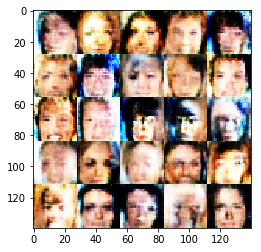

Epoch 1/1, Batch:1920... Discriminator Loss: 1.1514... Generator Loss: 0.9257
Epoch 1/1, Batch:1940... Discriminator Loss: 1.1008... Generator Loss: 1.3011
Epoch 1/1, Batch:1960... Discriminator Loss: 1.1604... Generator Loss: 0.9957
Epoch 1/1, Batch:1980... Discriminator Loss: 1.0234... Generator Loss: 0.8766
Epoch 1/1, Batch:2000... Discriminator Loss: 1.0268... Generator Loss: 1.4658
[None, 28, 28, 3]


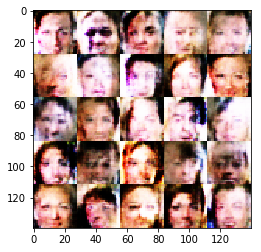

Epoch 1/1, Batch:2020... Discriminator Loss: 0.8655... Generator Loss: 1.4695
Epoch 1/1, Batch:2040... Discriminator Loss: 0.7067... Generator Loss: 2.1218
Epoch 1/1, Batch:2060... Discriminator Loss: 0.8038... Generator Loss: 1.2674
Epoch 1/1, Batch:2080... Discriminator Loss: 0.8918... Generator Loss: 2.8819
Epoch 1/1, Batch:2100... Discriminator Loss: 1.0263... Generator Loss: 1.1812
[None, 28, 28, 3]


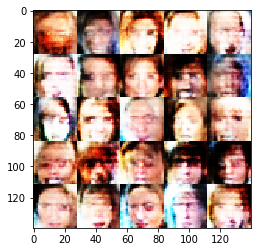

Epoch 1/1, Batch:2120... Discriminator Loss: 1.0653... Generator Loss: 1.0161
Epoch 1/1, Batch:2140... Discriminator Loss: 0.8594... Generator Loss: 1.1010
Epoch 1/1, Batch:2160... Discriminator Loss: 0.8843... Generator Loss: 1.6808
Epoch 1/1, Batch:2180... Discriminator Loss: 1.9195... Generator Loss: 0.5110
Epoch 1/1, Batch:2200... Discriminator Loss: 1.2016... Generator Loss: 1.3178
[None, 28, 28, 3]


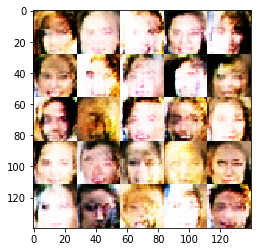

Epoch 1/1, Batch:2220... Discriminator Loss: 0.9112... Generator Loss: 1.1327
Epoch 1/1, Batch:2240... Discriminator Loss: 1.0547... Generator Loss: 0.9694
Epoch 1/1, Batch:2260... Discriminator Loss: 0.9926... Generator Loss: 0.7891
Epoch 1/1, Batch:2280... Discriminator Loss: 1.3794... Generator Loss: 0.8415
Epoch 1/1, Batch:2300... Discriminator Loss: 1.3060... Generator Loss: 0.9437
[None, 28, 28, 3]


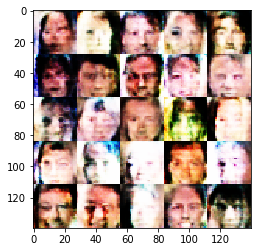

Epoch 1/1, Batch:2320... Discriminator Loss: 0.8196... Generator Loss: 1.2101
Epoch 1/1, Batch:2340... Discriminator Loss: 0.8714... Generator Loss: 1.2209
Epoch 1/1, Batch:2360... Discriminator Loss: 1.0107... Generator Loss: 0.8979
Epoch 1/1, Batch:2380... Discriminator Loss: 1.0862... Generator Loss: 0.8902
Epoch 1/1, Batch:2400... Discriminator Loss: 1.2040... Generator Loss: 0.8269
[None, 28, 28, 3]


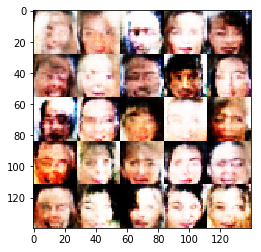

Epoch 1/1, Batch:2420... Discriminator Loss: 0.6427... Generator Loss: 2.6826
Epoch 1/1, Batch:2440... Discriminator Loss: 0.9861... Generator Loss: 1.3875
Epoch 1/1, Batch:2460... Discriminator Loss: 0.8838... Generator Loss: 1.1318
Epoch 1/1, Batch:2480... Discriminator Loss: 0.8612... Generator Loss: 0.9996
Epoch 1/1, Batch:2500... Discriminator Loss: 1.1656... Generator Loss: 0.8407
[None, 28, 28, 3]


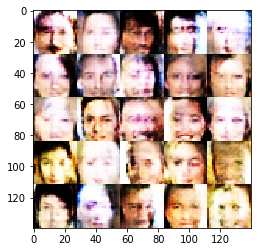

Epoch 1/1, Batch:2520... Discriminator Loss: 1.0038... Generator Loss: 1.3334
Epoch 1/1, Batch:2540... Discriminator Loss: 1.0487... Generator Loss: 0.8793
Epoch 1/1, Batch:2560... Discriminator Loss: 1.2182... Generator Loss: 1.5225
Epoch 1/1, Batch:2580... Discriminator Loss: 1.0931... Generator Loss: 0.7139
Epoch 1/1, Batch:2600... Discriminator Loss: 1.0587... Generator Loss: 0.9688
[None, 28, 28, 3]


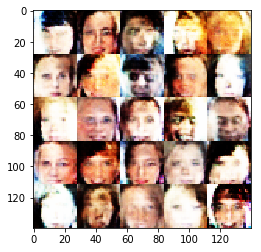

Epoch 1/1, Batch:2620... Discriminator Loss: 1.0587... Generator Loss: 0.9678
Epoch 1/1, Batch:2640... Discriminator Loss: 0.8867... Generator Loss: 1.3394
Epoch 1/1, Batch:2660... Discriminator Loss: 0.8294... Generator Loss: 1.0889
Epoch 1/1, Batch:2680... Discriminator Loss: 1.2734... Generator Loss: 0.8630
Epoch 1/1, Batch:2700... Discriminator Loss: 1.3292... Generator Loss: 0.7231
[None, 28, 28, 3]


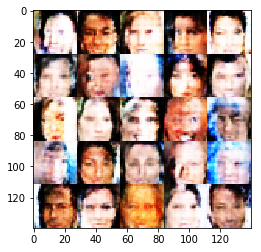

Epoch 1/1, Batch:2720... Discriminator Loss: 1.0874... Generator Loss: 0.8175
Epoch 1/1, Batch:2740... Discriminator Loss: 0.9933... Generator Loss: 1.4172
Epoch 1/1, Batch:2760... Discriminator Loss: 0.8995... Generator Loss: 1.2029
Epoch 1/1, Batch:2780... Discriminator Loss: 1.2252... Generator Loss: 0.7178
Epoch 1/1, Batch:2800... Discriminator Loss: 1.2039... Generator Loss: 0.8200
[None, 28, 28, 3]


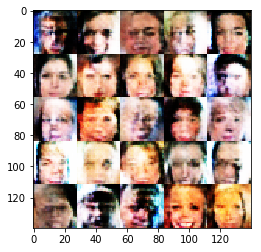

Epoch 1/1, Batch:2820... Discriminator Loss: 1.0148... Generator Loss: 0.9004
Epoch 1/1, Batch:2840... Discriminator Loss: 0.9660... Generator Loss: 0.7869
Epoch 1/1, Batch:2860... Discriminator Loss: 1.0411... Generator Loss: 1.0972
Epoch 1/1, Batch:2880... Discriminator Loss: 0.5045... Generator Loss: 2.7759
Epoch 1/1, Batch:2900... Discriminator Loss: 1.1048... Generator Loss: 0.9189
[None, 28, 28, 3]


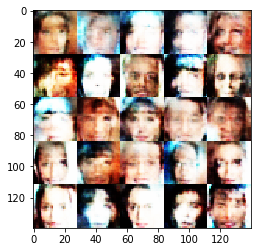

Epoch 1/1, Batch:2920... Discriminator Loss: 1.0590... Generator Loss: 0.9518
Epoch 1/1, Batch:2940... Discriminator Loss: 0.8575... Generator Loss: 1.4138
Epoch 1/1, Batch:2960... Discriminator Loss: 0.9029... Generator Loss: 1.2328
Epoch 1/1, Batch:2980... Discriminator Loss: 1.3036... Generator Loss: 0.6820
Epoch 1/1, Batch:3000... Discriminator Loss: 1.1779... Generator Loss: 0.8764
[None, 28, 28, 3]


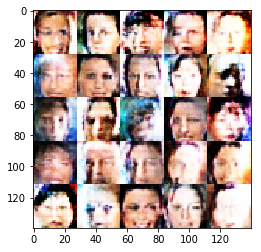

Epoch 1/1, Batch:3020... Discriminator Loss: 0.7758... Generator Loss: 1.3517
Epoch 1/1, Batch:3040... Discriminator Loss: 0.9460... Generator Loss: 1.2968
Epoch 1/1, Batch:3060... Discriminator Loss: 1.3051... Generator Loss: 1.0805
Epoch 1/1, Batch:3080... Discriminator Loss: 0.8140... Generator Loss: 1.2814
Epoch 1/1, Batch:3100... Discriminator Loss: 1.2350... Generator Loss: 0.6893
[None, 28, 28, 3]


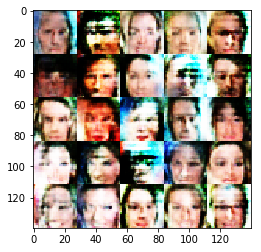

Epoch 1/1, Batch:3120... Discriminator Loss: 0.8470... Generator Loss: 1.6588
Epoch 1/1, Batch:3140... Discriminator Loss: 1.1049... Generator Loss: 0.8646
Epoch 1/1, Batch:3160... Discriminator Loss: 1.3028... Generator Loss: 1.3583


In [105]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.